![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [297]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin
from scipy.stats import shapiro, f_oneway, kruskal
import scipy.stats as stats


In [298]:
# DF of woman/men football international matches
df_women = pd.read_csv('women_results.csv')
df_men = pd.read_csv('men_results.csv')

# Visualize the df
df_women.head(3)

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament
0,0,1969-11-01,Italy,France,1,0,Euro
1,1,1969-11-01,Denmark,England,4,3,Euro
2,2,1969-11-02,England,France,2,0,Euro


In [299]:
# Columns types
df_women.dtypes

Unnamed: 0     int64
date          object
home_team     object
away_team     object
home_score     int64
away_score     int64
tournament    object
dtype: object

In [300]:
# Transform date columns object to datetime type.
df_women['date'] = pd.to_datetime(df_women['date'])
df_men['date'] = pd.to_datetime(df_men['date'])

# Visualize changes
df_men.dtypes

Unnamed: 0             int64
date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
dtype: object

In [301]:
# Goals in a match column
df_women['Total_goals_match'] = df_women['home_score'] + df_women['away_score']
df_men['Total_goals_match'] = df_men['home_score'] + df_men['away_score']

# Filter by requirements (Fifa World Cup games after 2002-01-01)
df_women_filter = df_women[(df_women['date'] > '2002-01-01') & (df_women['tournament'] == 'FIFA World Cup')]
df_men_filter = df_men[(df_men['date'] > '2002-01-01') & (df_men['tournament'] == 'FIFA World Cup')]

# Create group
df_women_filter['group'] = 'women'
df_men_filter['group'] = 'men'


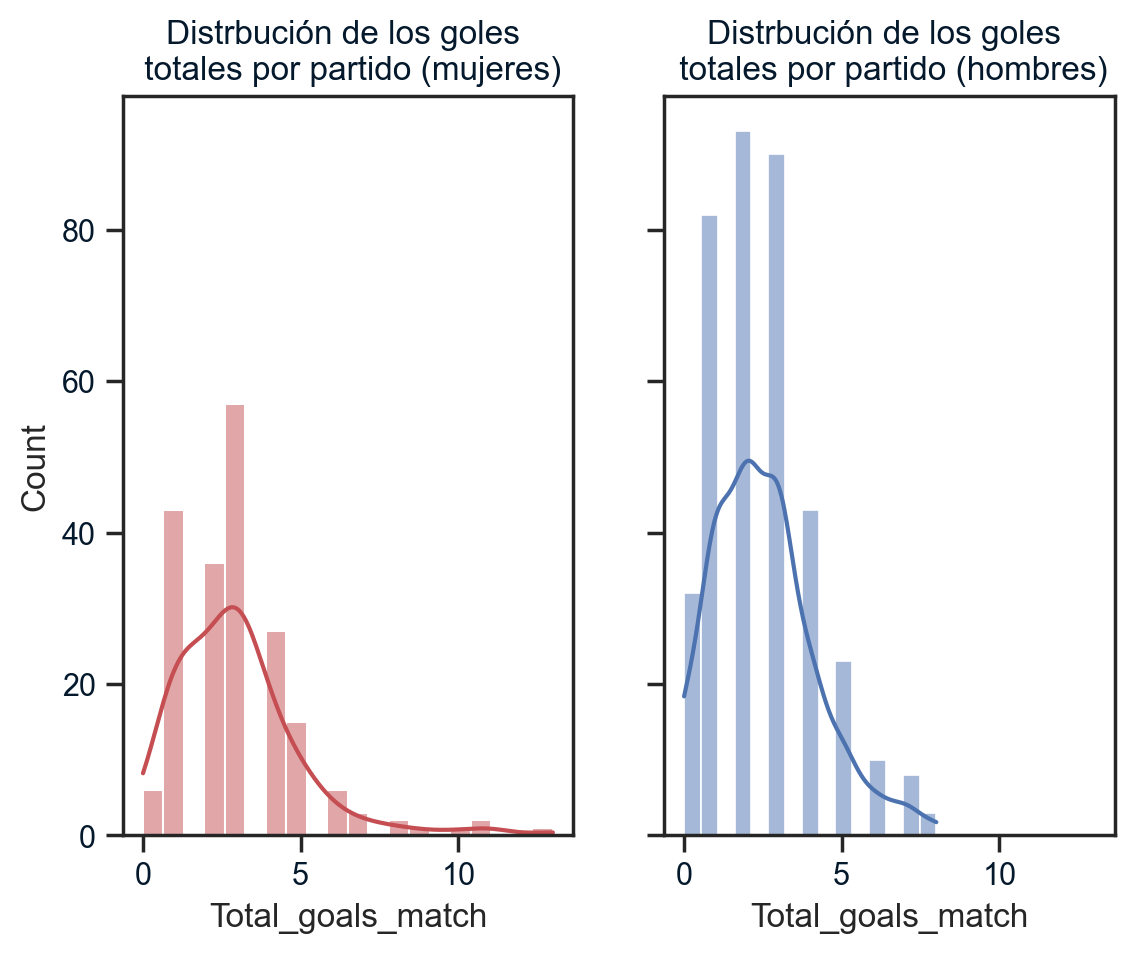

In [302]:
# Visualize the total goals distribution

# Set subplots, same axes
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

# Histogram women total goals distribution with kde = True to see density distribution. 
sns.histplot(df_women_filter['Total_goals_match'], ax = ax[0], color = 'r', kde = True)

# Histogram men total goals distribution with kde = True to see density distribution. 
sns.histplot(df_men_filter['Total_goals_match'], ax = ax[1], color = 'b', kde = True)

# Some subplots adjustements 
ax[0].set_title('Distrbución de los goles \n totales por partido (mujeres)')
ax[1].set_title('Distrbución de los goles \n totales por partido (hombres)')
plt.show()

In [303]:
# Goals distribution dont follow a normal distribution

# Get total goals mean and visualize in a dict
mean_woman = df_women['Total_goals_match'].mean()
mean_men = df_men['Total_goals_match'].mean()
mean_dict = {'men_mean': mean_men, 'woman_men': mean_woman}
mean_dict

{'men_mean': 2.9193515658467297, 'woman_men': 3.704135954135954}

In [304]:
# Could be a significant differences between women and men.

In [305]:
# Combine both data
both = pd.concat([df_men_filter, df_women_filter], axis = 0, ignore_index= True)

# DF concat with only 2 important columns
df = both[['Total_goals_match', 'group']]
df.head(3)

,Total_goals_match,group
0,1,men
1,8,men
2,2,men


In [306]:
# Pivot df
df_w = df.pivot(columns= 'group', values = 'Total_goals_match')

In [307]:
# Test Mann-Whitney alternative 'greater' (HA: The mean number of goals scored in women's international soccer matches is greater than men's.)
test = pingouin.mwu(x = df_w['women'], y = df_w['men'], alternative = 'greater')

# Dict empty
result_dict = {}
# Use a 10% significance level.
alpha = 0.1

# Extract p_val from test MWU
p_val = test['p-val'][0]

# Condiction to accept or reject in case p_val
if p_val < alpha:
    result_dict.update({'p_val':p_val, 'result': 'reject'})
else:
    result_dict.update({'p_val':p_val, 'result': 'fail to reject'})

# Visualize results
result_dict

# Reject H0

{'p_val': 0.005106609825443641, 'result': 'reject'}

In [308]:
# Visualize some aspects. Goals/Teams
# World Champions Nationals Team in XXI century

# DF filter by XXI century
df_fc = df_men[df_men['date'] > '2000-01-01']

# List of World Champions Nationals Team in XXI century
world_c =  ["Brazil", "Italy", "Spain", "Germany", "France", "Argentina"]

# Empty team columns (world_c will be there)
df_fc['team'] = None 

# Loop to get the team who play (has to be WWC)
for team in world_c:
    condition = (df_men['home_team'] == team) | (df_fc['away_team'] == team)
    df_fc.loc[condition, 'team'] = team

# Drop nulls
df_fc = df_fc.dropna(subset =['team'])

# Visualize df
df_fc.head(3)

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,Total_goals_match,team
22842,22842,2000-01-26,Spain,Poland,3,0,Friendly,3,Spain
22962,22962,2000-02-23,Croatia,Spain,0,0,Friendly,0,Spain
22963,22963,2000-02-23,England,Argentina,0,0,Friendly,0,Argentina


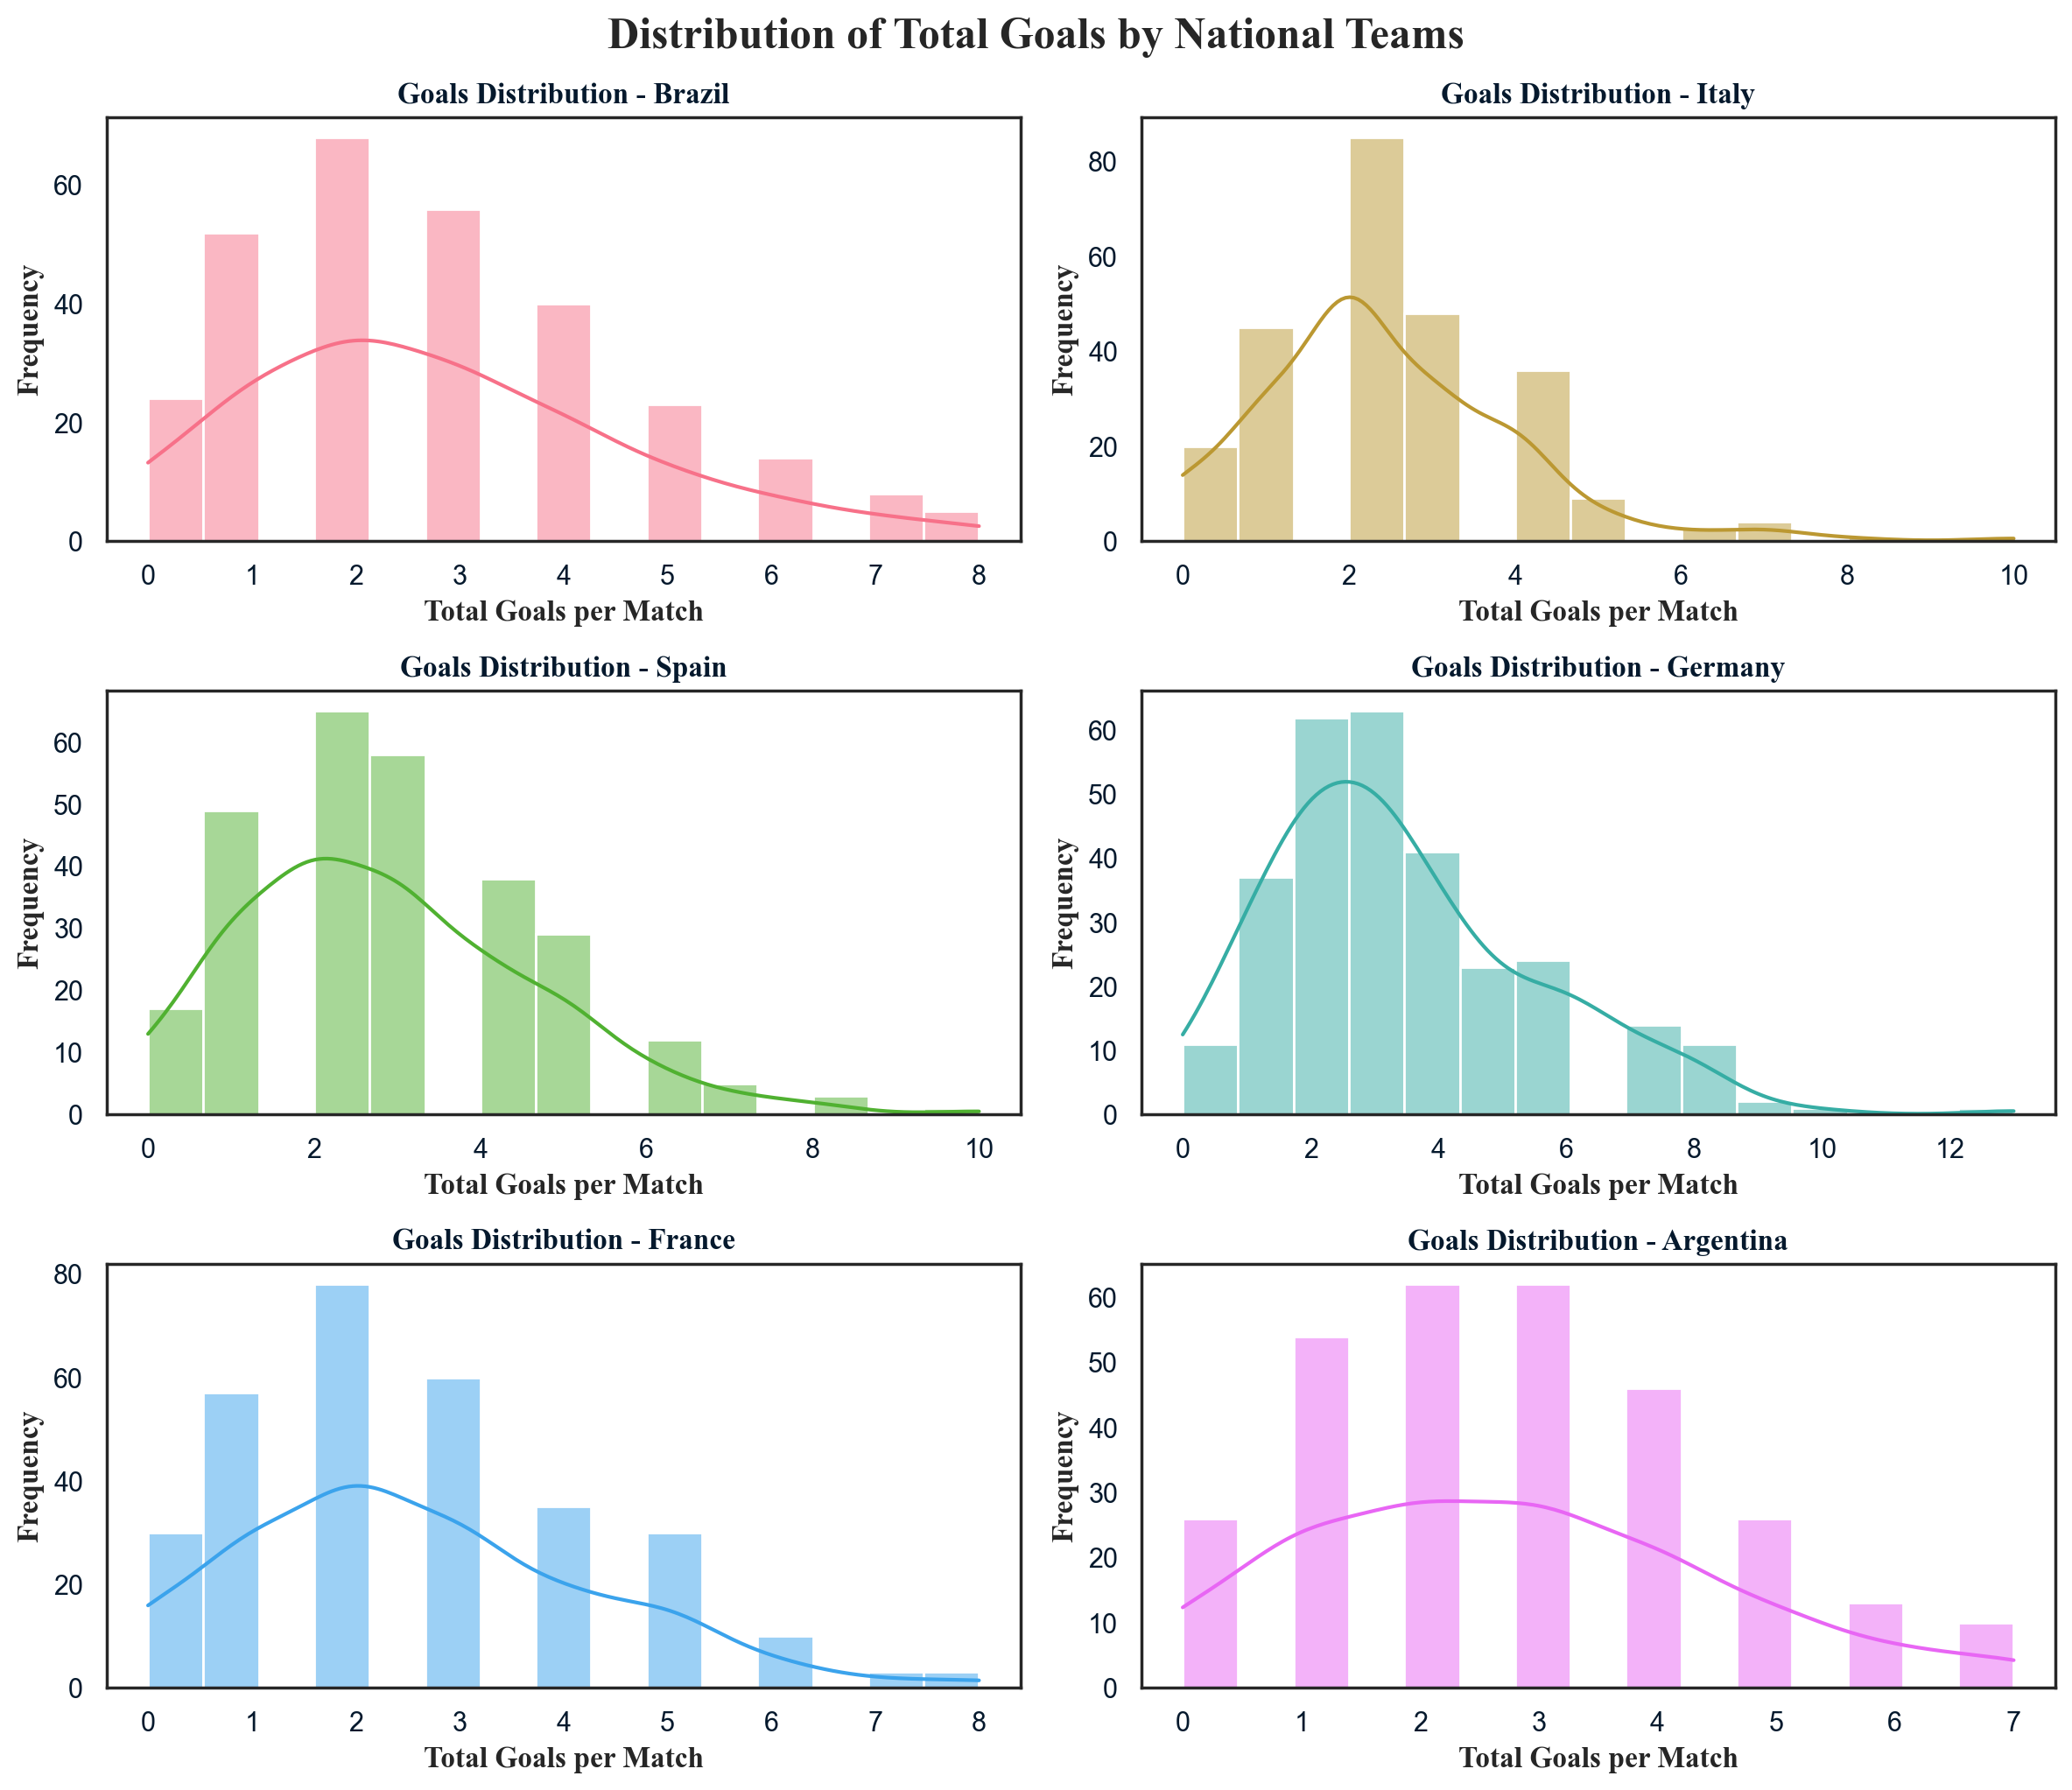

In [309]:
# Count WWC vs Total goals

# Set theme
sns.set_theme(style="white")

# Size and some configurations
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten()

# Palette for every world champions.
palette = sns.color_palette("husl", len(world_c))

# A subplot for every wc.
for i, team in enumerate(world_c):
    ax = axes[i]
    sns.histplot(df_fc[df_fc['team'] == team]['Total_goals_match'], bins=15, kde=True, color=palette[i], ax=ax)
    ax.set_title(f"Goals Distribution - {team}", fontname="Times New Roman", fontsize=12, fontweight="bold")
    ax.set_xlabel("Total Goals per Match", fontname="Times New Roman", fontweight="bold")
    ax.set_ylabel("Frequency", fontname="Times New Roman",  fontweight="bold")

# Anothers confi.
plt.tight_layout()
plt.suptitle('Distribution of Total Goals by National Teams',fontname="Times New Roman", fontsize=18, fontweight="bold", y=1.02)
plt.show()



In [310]:
# Get difference_score and winner columns
df_fc['difference_score'] = np.abs((df_fc['home_score'])-(df_fc['away_score']))
df_fc['winner'] = np.where(
    df_fc['home_score'] > df_fc['away_score'], df_fc['home_team'],
    np.where(df_fc['home_score'] < df_fc['away_score'], df_fc['away_team'], 'Draw')
)

In [311]:
# Mean goals by team
mean_by_winner = df_fc.groupby('winner')['difference_score'].mean().sort_values(ascending = False)
mean_by_winner_wc = mean_by_winner.loc[mean_by_winner.index.isin(world_c)]

# See distribution (normal o not)
# First create wc_df with winners wc.
wc_df = df_fc[df_fc['winner'].isin(world_c)]

# Test shapiro.
stat, p = shapiro(wc_df['difference_score'])

# Empty dict to save the results
resultados_dict = {}

# Conditional to get results
if p > 0.05:
    resultados_dict.update({'p:val':p, 'resultado' : 'Distribución normal'})
else:
    resultados_dict.update({'p:val':p, 'resultado' : 'Distribución no normal'})
    
resultados_dict

{'p:val': 1.1100122699770152e-35, 'resultado': 'Distribución no normal'}

Text(0, 0.5, 'Porcentaje de victorias')

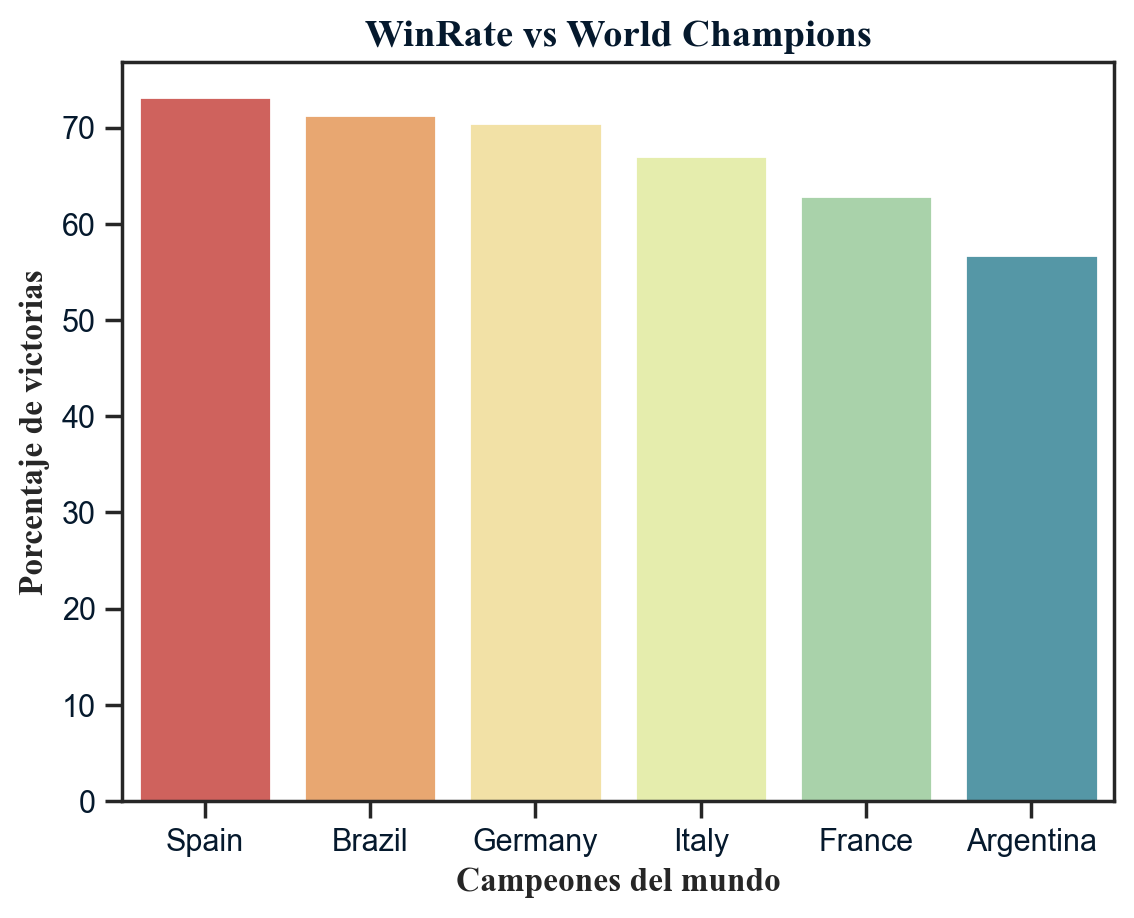

In [312]:
# Win porcentage.

# Filter by no friendly matches
win_por_df = df_fc[df_fc['tournament'] != 'Friendly']

# All Matches played by any team.
match_played = win_por_df['team'].value_counts()

# Wins of each team
wins = win_por_df['winner'].value_counts()

# Get win_rate.
win_rate = (wins/match_played *100)

# Drop na values = Wc winners
wr_wc = win_rate.dropna().sort_values(ascending = False)

# Barplot win_rate/world champions
sns.set_theme(style = 'ticks')
sns.barplot(data = wr_wc, palette = "Spectral")
plt.title('WinRate vs World Champions', fontname="Times New Roman", fontweight="bold", fontsize = '14')
plt.xlabel('Campeones del mundo', fontname="Times New Roman", fontweight="bold", fontsize = '12')
plt.ylabel('Porcentaje de victorias',fontname="Times New Roman", fontweight="bold", fontsize = '12')

In [313]:
# Test

win_rate_df = win_rate.dropna().reset_index()
win_rate_df.columns = ['team', 'win_rate']

groups = [win_rate_df[win_rate_df['team'] == team]['win_rate'] for team in win_rate_df['team'].unique()]

stadistics, p_value = kruskal(*groups)

# Empty dict to save the results
t_dict = {}

# Conditional to get results
if p_value > 0.05:
    t_dict.update({'p:val':p_value, 'resultado' : 'No se rechaza H0'})
else:
    t_dict.update({'p:val':p_value, 'resultado' : 'Se rechaza H0, existen diferencias significativas'})

t_dict

{'p:val': 0.4158801869955079, 'resultado': 'No se rechaza H0'}

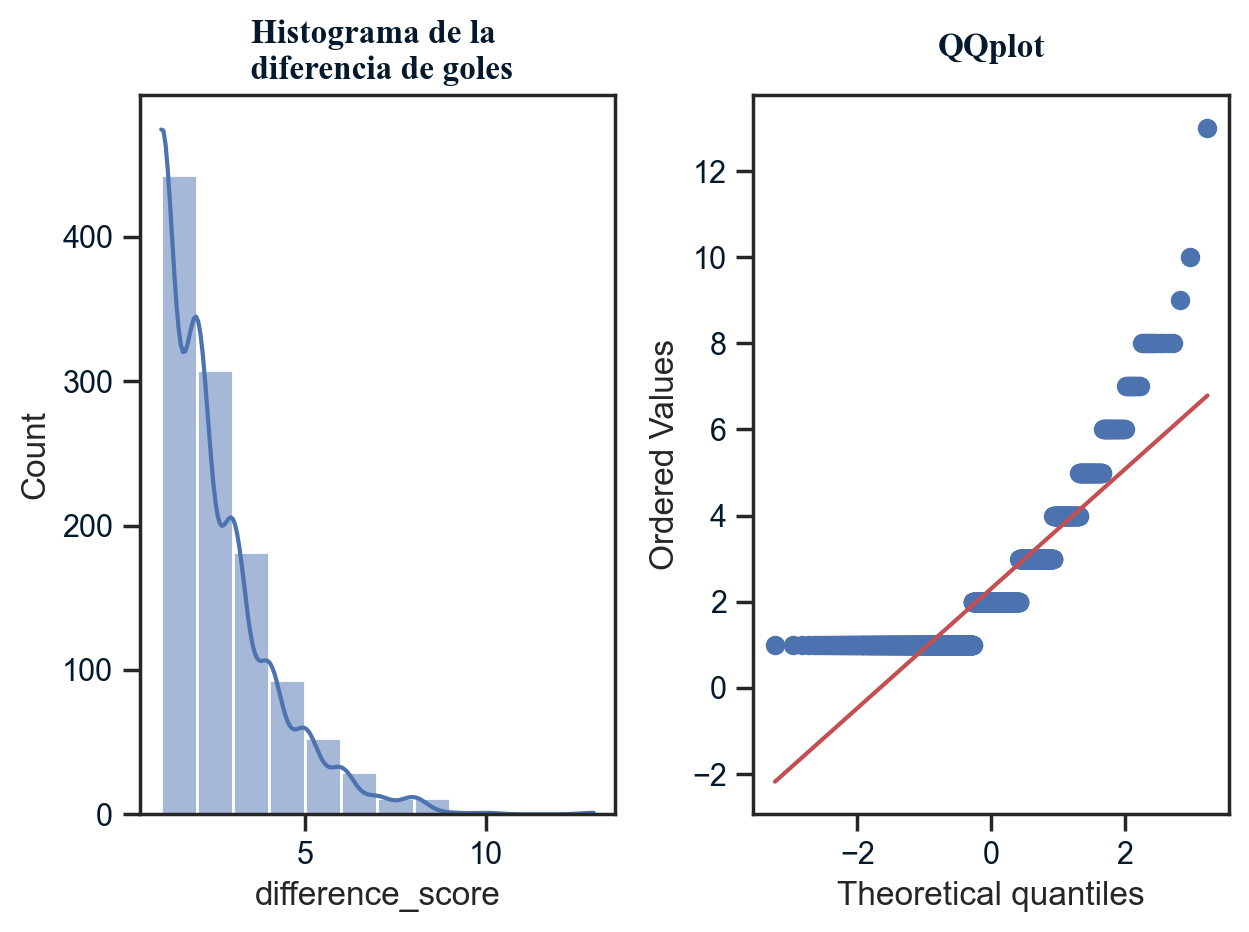

In [314]:
# Visualize the results

# Get 2 subplots
fig, ax = plt.subplots(1, 2)

# Set theme for the subplots
sns.set_theme(style = 'ticks')

# Hist to see distribution of difference goals
sns.histplot(wc_df['difference_score'], kde = True, bins = 12, ax = ax[0])
ax[0].set_title('Histograma de la \n diferencia de goles', fontname="Times New Roman", fontweight="bold")

# QQplot to visualize the no normal distribution
stats.probplot(wc_df['difference_score'], dist="norm", plot=ax[1])
ax[1].set_title('QQplot',fontname="Times New Roman", fontweight="bold", y = 1.03)

# Adjust plots
plt.tight_layout()

In [315]:
# No normal distribution. Kruskal

# Hipotesis nula: No existen diferencias significativas entre equipos
# Hipotesis alternativa: Existen diferencias significativas entre algunos de los equipos con el resto.

# Test
statics, p_test = kruskal((*[wc_df[wc_df['team'] == team]['difference_score'] for team in world_c]))

# Empty dict to save the results
test_dict = {}

# Conditional to get results
if p > 0.05:
    test_dict.update({'p:val':p_test, 'resultado' : 'No se rechaza H0'})
else:
    test_dict.update({'p:val':p_test, 'resultado' : 'Se rechaza H0, existen diferencias significativas'})
    
test_dict

{'p:val': 0.000654331378058221,
 'resultado': 'Se rechaza H0, existen diferencias significativas'}

In [316]:
# Analisis post-hoc (Turkey) to see the team with significant difference score between others teams.
resultados_post_hoc = pingouin.pairwise_tukey(data = wc_df, dv = 'difference_score', between = 'team')

# Get the results with significant differences
significant_differences = resultados_post_hoc[resultados_post_hoc['p-tukey'] < 0.05]

# How many time a team have a significance difference with each other
team_counts = significant_differences['A'].value_counts() + significant_differences['B'].value_counts()

# The team with most significance difference with each other
most_sig_team = team_counts.idxmax()

# Team and the times thats occured
most_sig_team, team_counts[most_sig_team]

('Germany', 3.0)